Use the Storm Prediction Center tornado dataset https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv

Also, use the ENSO, PDO, NAO, and AO dataframe 


1) Aggregate the tornado data over the following states into a monthly count of tornadoes:
   
   - Illinois
   
   - Indiana
   
   - Wisconsin
   
   - Michigan
   
   - Missouri
   
   - Iowa
   
   - Minnesota
2. Merge this monthly tornado dataset with the ENSO, MJO, NAO, and AO dataframe created in Module 4 Notebook 1.

3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

5. Perform a feature importance and multipass permutation analysis of your features.

6. Create a SHAP Summary Plot showing feature importance and feature effects.

7. Create a SHAP Feature Dependence for the ENSO index.

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?


In [204]:
import pandas as pd

df_t = pd.read_csv('https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv')

In [211]:
df_states = df_t.loc[df_t['st'].isin(['IL', 'IN', 'WI','MI', 'MO', 'IA', 'MN'])] #filter for states we want, save into file
df_states.set_index(['date'], inplace = True)
df_states.index = pd.to_datetime(df_states.index)

df_states

,om,yr,mo,dy,time,tz,st,stf,stn,mag,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
date,,,,,,,,,,,,,,,,,,,,,
1950-12-02,198,1950,12,2,15:00:00,3,IL,17,7,2,...,18.80,50,1,1,1,119,117,0,0,0
1950-12-02,199,1950,12,2,16:00:00,3,IL,17,8,3,...,18.00,200,1,1,1,119,5,0,0,0
1950-12-02,201,1950,12,2,17:30:00,3,IL,17,9,1,...,9.60,50,1,1,1,157,0,0,0,0
1950-01-25,5,1950,1,25,19:30:00,3,MO,29,2,2,...,2.30,300,1,1,1,93,0,0,0,0
1950-01-25,6,1950,1,25,21:00:00,3,IL,17,3,2,...,0.10,100,1,1,1,91,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,620531,2021,9,17,02:08:00,3,MN,27,0,0,...,0.81,75,1,1,1,37,0,0,0,0
2021-09-17,620532,2021,9,17,02:08:00,3,MN,27,0,0,...,1.02,50,1,1,1,37,0,0,0,0
2021-09-20,620534,2021,9,20,15:47:00,3,MN,27,0,0,...,5.66,100,1,1,1,109,0,0,0,0


In [287]:
#monthly = (df_states.groupby([df_states['date'].dt.year.rename('year'), df_states['date'].dt.month_name().rename('month')])).size()

monthly = df_states.groupby(pd.Grouper(freq='MS')).size() #group by month start using grouper to maintain date-time format
monthly_df = pd.DataFrame(monthly) #save into DF
monthly_df.columns = ['Tornados'] #rename column
monthly_df

,Tornados
date,
1950-01-01,4
1950-02-01,0
1950-03-01,1
1950-04-01,0
1950-05-01,2
...,...
2021-08-01,63
2021-09-01,7
2021-10-01,42


In [247]:
#2. Merge this monthly tornado dataset with the ENSO, NAO, and AO dataframe created in Module 4 Notebook 1.

#import data

enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/pdo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=14, engine='python')
nao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/nao.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')
ao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/ao.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')


/var/folders/3h/_9j4h7zd7rz513ts0v8w3vdm0000gn/T/ipykernel_3830/3339597924.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')
/var/folders/3h/_9j4h7zd7rz513ts0v8w3vdm0000gn/T/ipykernel_3830/3339597924.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdo = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/pdo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=14, engine='python')
/var/folders/3h/_9j4h7zd7rz513ts0v8w3vdm0000gn/T/ipykernel_3830/3339597924.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao = pd.read_csv

In [274]:
# Create a new DataFrame with a date range from January 1948 to December 2022 with a monthly frequency
enso_new = pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

enso_new['Date'] = pd.date_range(start='1948-01-01', end='2022-12-01', freq="MS")
nao_new['Date'] = pd.date_range(start='1948-01-01', end='2022-12-01', freq="MS")
pdo_new['Date'] = pd.date_range(start='1948-01-01', end='2022-12-01', freq="MS")
ao_new['Date'] = pd.date_range(start='1948-01-01', end='2022-12-01', freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')


In [277]:
#len(enso.loc[:,1:].stack().values)
#len(nao.loc[:,1:].stack().values)
enso_new['ENSO']=enso.loc[:,1:].stack().values[:900] #len of enso and nao go beyond the date range which is 900. won't stack unless specified. 
nao_new['NAO']=nao.loc[:,1:].stack().values[:900]
pdo_new['PDO']=pdo.loc[:,1:].stack().values
ao_new['AO']=ao.loc[:,1:].stack().values

In [282]:
#import the merge code from Module 4
import numpy as np
import warnings
warnings.filterwarnings('ignore')

newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)


newdf_all['PDO'][newdf_all['PDO'] <= -9.9] = np.nan
newdf_all['ENSO'][newdf_all['ENSO'] <= -9.9] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all['NAO'][newdf_all['NAO'] <= -99.9] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all['AO'][newdf_all['AO'] <= -99.9] = np.nan
newdf_all



,ENSO,PDO,NAO,AO
Date,,,,
1948-01-01,0.26,-0.11,NaN,-0.060
1948-02-01,0.43,-0.74,NaN,0.627
1948-03-01,0.72,-0.03,NaN,-0.008
1948-04-01,0.21,-1.33,NaN,0.555
1948-05-01,0.24,-0.23,NaN,0.072
...,...,...,...,...
2022-08-01,-1.45,NaN,1.76,1.284
2022-09-01,-1.79,NaN,-1.42,-0.624
2022-10-01,-1.78,NaN,-0.27,NaN


In [339]:
t_data = pd.merge(newdf_all,monthly_df, left_index=True, right_index=True)

# Rename index 
t_data.rename_axis('Date', inplace=True)


t_data

,ENSO,PDO,NAO,AO,Tornados
Date,,,,,
1950-01-01,-0.74,-2.13,0.56,0.368,4
1950-02-01,-1.70,-2.91,0.01,-1.747,0
1950-03-01,-1.43,-1.13,-0.78,-1.860,1
1950-04-01,-1.29,-1.20,0.65,0.538,0
1950-05-01,-1.22,-2.23,-0.50,-0.773,2
...,...,...,...,...,...
2021-08-01,-0.62,-1.12,-0.49,-0.602,63
2021-09-01,-0.69,-1.53,-0.06,0.318,7
2021-10-01,-1.00,-2.55,-1.98,-0.414,42


3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.


In [340]:
x = t_data.drop('Tornados', axis=1) #x data
y = t_data['Tornados'] #target

In [443]:
# train test split

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


xtrain, xtest, ytrain, ytest=train_test_split(x, y) #set to default split? 

In [444]:
#we aren't provided the grid for parameters so I am skipping the randomsearchcv, which seemed to provide optimized parameters within the given specified grid?

rf  = RandomForestRegressor(random_state = 1)

rf.fit(xtrain, ytrain)
y_pred = rf.predict(xtest)

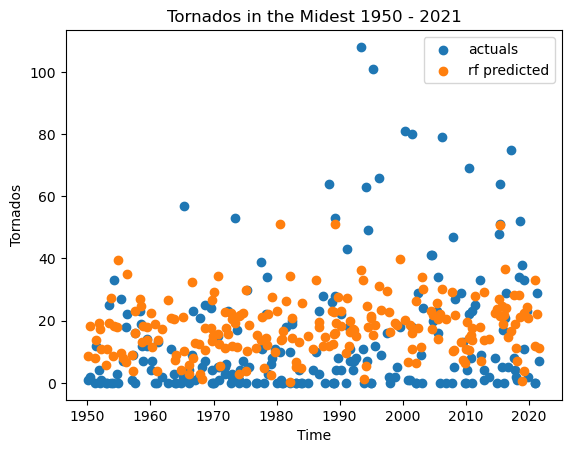

In [445]:
import matplotlib.pyplot as plt
plt.scatter(ytest.index, ytest, label = 'actuals') #where index = x
plt.scatter(ytest.index, y_pred, label ='rf predicted') #where index = date
plt.xlabel('Time')
plt.ylabel('Tornados')
plt.title('Tornados in the Midest 1950 - 2021')
plt.legend()

In [446]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

In [447]:
print('rmse', rmse)
print('r^2', r2)

rmse 20.744397146288993
r^2 -0.09424181448962576


4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.


-- my understanding of this is that we need to set categories for each month... so instead of datetime, we need to set months on the categorization of 1:12
-- based on merged dataset, not re-reading in the original 

In [428]:
months = t_data.index.month.unique() #extract month from datetime index, take unique values to save 

t_data['month'] = t_data.index.month

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='Date')

In [357]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas') #output to pandas df

ohe_df= ohe.fit_transform(t_data[['month']]) #transform

In [360]:
# merge on shared index

ohe_merge = pd.merge(t_data, ohe_df, left_index=True, right_index=True)

ohe_merge

,ENSO,PDO,NAO,AO,Tornados,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,,,,,,
1950-01-01,-0.74,-2.13,0.56,0.368,4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-02-01,-1.70,-2.91,0.01,-1.747,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-03-01,-1.43,-1.13,-0.78,-1.860,1,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-04-01,-1.29,-1.20,0.65,0.538,0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-05-01,-1.22,-2.23,-0.50,-0.773,2,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-0.62,-1.12,-0.49,-0.602,63,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-09-01,-0.69,-1.53,-0.06,0.318,7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-10-01,-1.00,-2.55,-1.98,-0.414,42,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [365]:
# redo test-train

x_ohe = ohe_merge.drop(['month', 'Tornados'], axis=1)
y_ohe = ohe_merge['Tornados']

In [448]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x_ohe, y_ohe) #set to default split


rf2  = RandomForestRegressor(random_state = 1) #use same random state
rf2.fit(xtrain2, ytrain2)
y_pred2 = rf2.predict(xtest2)

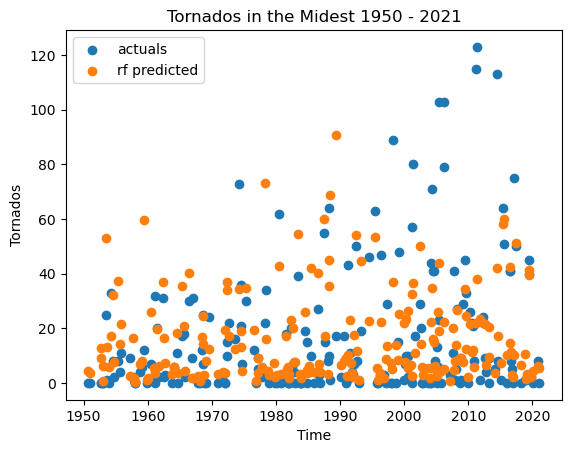

In [449]:
import matplotlib.pyplot as plt
plt.scatter(ytest2.index, ytest2, label = 'actuals') #where index = x
plt.scatter(ytest2.index, y_pred2, label ='rf predicted') #where index = date
plt.xlabel('Time')
plt.ylabel('Tornados')
plt.title('Tornados in the Midest 1950 - 2021')
plt.legend()

#scatter plot looks the same.. 

In [450]:
rmse2 = np.sqrt(mean_squared_error(ytest2, y_pred2))
r22 = r2_score(ytest2, y_pred2)


print('rmse', rmse)
print('r^2', r2)
print('rmse ohe', rmse2)
print('r^2 ohe', r22)

rmse 20.744397146288993
r^2 -0.09424181448962576
rmse ohe 20.451714464490184
r^2 ohe 0.27388963786994935


5. Perform a feature importance and multipass permutation analysis of your features.



In [381]:
ohe_merge

,ENSO,PDO,NAO,AO,Tornados,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,,,,,,
1950-01-01,-0.74,-2.13,0.56,0.368,4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-02-01,-1.70,-2.91,0.01,-1.747,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-03-01,-1.43,-1.13,-0.78,-1.860,1,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-04-01,-1.29,-1.20,0.65,0.538,0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950-05-01,-1.22,-2.23,-0.50,-0.773,2,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-0.62,-1.12,-0.49,-0.602,63,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-09-01,-0.69,-1.53,-0.06,0.318,7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-10-01,-1.00,-2.55,-1.98,-0.414,42,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


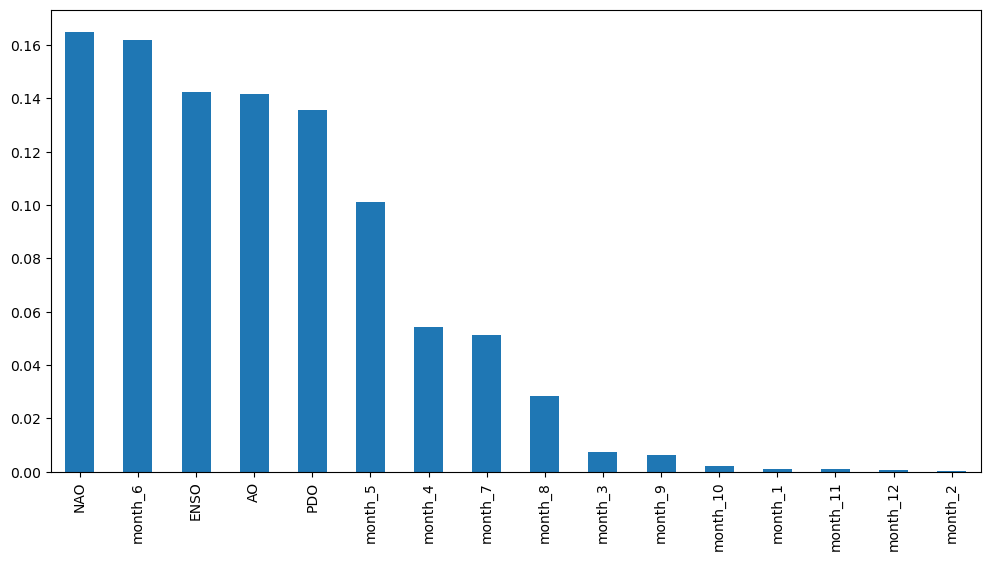

In [389]:
#pipeline not made because data was already processed.

# feature importance

#use the model for feature importance. 
importance = pd.Series(rf2.feature_importances_)
importance.index = ohe_merge.drop(['Tornados','month'], axis=1).columns # drop target and month column
importance.sort_values(inplace=True, ascending=False)
    importance.plot.bar(figsize=(12,6))
    plt.show()


#most importance features: NAO, month 6




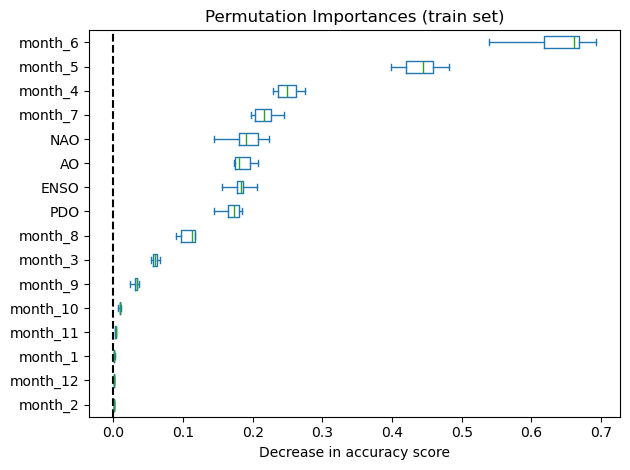

In [393]:
# multipass permutation analysis of your features. code ulled from notebook 5
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf2, xtrain2, ytrain2, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_ohe.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

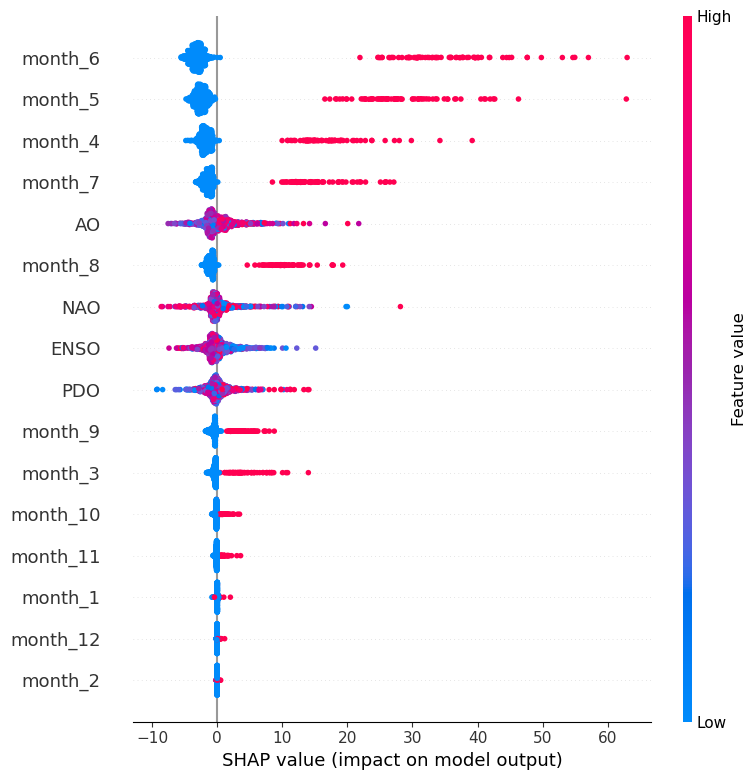

In [419]:
#6. Create a SHAP Summary Plot showing feature importance and feature effects.
import shap

#to get summary plot you need to get shap values so shap explainer (rf model) >>get shap_values from x values

explainer = shap.TreeExplainer(rf2) 
shap_test = explainer(xtest2) #test values
shap_values = explainer.shap_values(x_ohe)
shap.summary_plot(shap_values, x_ohe)

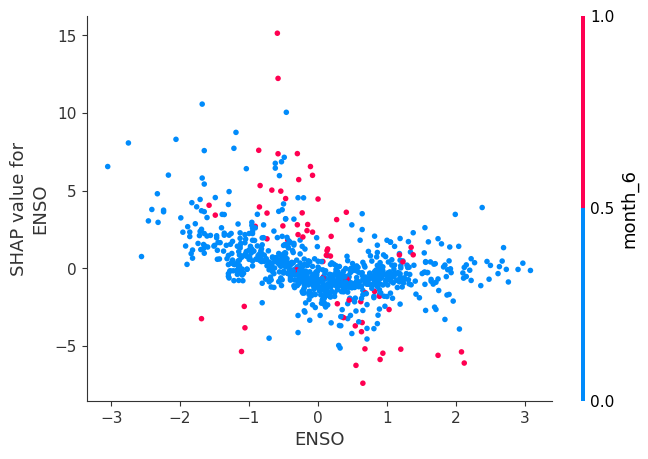

In [424]:
#7. Create a SHAP Feature Dependence for the ENSO index.


#for name in xtrain2.columns:
#    shap.dependence_plot(name, shap_values, x_ohe)

shap.dependence_plot('ENSO', shap_values, x_ohe) 

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?

There are certain months that have consistenly shown high importance to the model in every XAI plot. For example, Month 6 (June) is clear high ranked feature in our feature importance and permutation importance. Month 6 is auto detected by the ENSO plot as well. 


The SHAP summary shows that months 4-7 generally have the greatest impact pushing the model up. ENSO, PDO, AO and NAO all have relatively similar moderate importance to the model. While months 4-7 seem to be ranked fairly consistently between each model, AO and NAO appear to swap between models as the most important feature within their subgroup. 

Months 12, 1, and 2 show the least importance across models, which is also useful since those months take place around the same time of year, winter. From this analysis alone (if I knew nothing about meteorology), I could assume that winter would not contribute to a higher frequency of tornados, unlike Spring through Summer. 